In [1]:
!pip install hdbscan umap-learn sentence-transformers matplotlib

In [2]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import re

In [3]:
def read_csv_dataset(file_path, sep=','):
    return pd.read_csv(file_path, sep=sep)

def convert_timestamps_to_datetime(df, timestamp_column_name='timestamp', timestamp_unit='s'):
    df['datetime'] = pd.to_datetime(df[timestamp_column_name], unit=timestamp_unit)
    return df

def get_data(file_path, sep=',', timestamp_column_name='timestamp', timestamp_unit='s'):
    df = read_csv_dataset(file_path, sep=sep)
    df = convert_timestamps_to_datetime(df, timestamp_column_name, timestamp_unit)
    print(f"Dataset shape: {df.shape}")
    return df

In [4]:
failures_03_05_df = get_data('/Users/arinagoncharova/Documents/diploma/EDA/Aiops-Dataset/groundtruth/groundtruth-2022-05-03.csv')
failures_03_05_df.head()

Dataset shape: (50, 5)


,timestamp,level,cmdb_id,failure_type,datetime
0,1651510238,pod,shippingservice2-0,Kubernetes Container Memory Load,2022-05-02 16:50:38
1,1651511197,node,node-2,Node Memory Consumption,2022-05-02 17:06:37
2,1651512508,node,node-2,Node Disk Space Consumption,2022-05-02 17:28:28
3,1651515718,pod,adservice2-0,Kubernetes Container Network Resource Packet C...,2022-05-02 18:21:58
4,1651518109,pod,paymentservice-1,Kubernetes Container Network Packet Loss,2022-05-02 19:01:49


In [5]:
service_failures_03_05_df = failures_03_05_df[failures_03_05_df['level'] == 'service']
service_failures_03_05_df

,timestamp,level,cmdb_id,failure_type,datetime
5,1651519906,service,productcatalogservice,Kubernetes Container Network Resource Packet D...,2022-05-02 19:31:46
8,1651523554,service,recommendationservice,Kubernetes Container Read I/O Load,2022-05-02 20:32:34
10,1651529574,service,frontend,Kubernetes Container Network Resource Packet D...,2022-05-02 22:12:54
13,1651533257,service,recommendationservice,Kubernetes Container Network Packet Loss,2022-05-02 23:14:17
14,1651535538,service,cartservice,Kubernetes Container Network Packet Loss,2022-05-02 23:52:18
16,1651538629,service,emailservice,Kubernetes Container Write I/O Load,2022-05-03 00:43:49
18,1651544319,service,frontend,Kubernetes Container Write I/O Load,2022-05-03 02:18:39
19,1651545391,service,adservice,Kubernetes Container Read I/O Load,2022-05-03 02:36:31
21,1651551592,service,currencyservice,Kubernetes Container Network Resource Packet C...,2022-05-03 04:19:52
22,1651553048,service,checkoutservice,Kubernetes Container CPU Load,2022-05-03 04:44:08


In [6]:
logs_03_05_service_df = get_data('/Users/arinagoncharova/Documents/diploma/EDA/Aiops-Dataset/data/2022-05-03/log/all/log_filebeat-testbed-log-service.csv')
logs_03_05_service_df.head()

Dataset shape: (5444332, 6)


,log_id,timestamp,cmdb_id,log_name,value,datetime
0,Cp6Bt38B8vQa58bZsQau,1651507200,frontend-1,log_frontend-service_application,"severity: debug, message: request complete",2022-05-02 16:00:00
1,EZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 16:00:00
2,FZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00
3,Fp6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Request finished in 0.6231ms 200 applicat...,2022-05-02 16:00:00
4,F56Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00


In [7]:
logs_03_05_service_df.shape

(5444332, 6)

In [8]:
# filter only 10 min before and after incident service logs

service_logs = logs_03_05_service_df.copy()
incidents = service_failures_03_05_df.copy()

logs_sorted = service_logs.sort_values('datetime')
incidents_sorted = incidents.sort_values('datetime')

service_logs_near_incident = pd.merge_asof(
    logs_sorted,
    incidents_sorted[['datetime']].rename(
        columns={'datetime': "matched_incident_timestamp"}
    ),
    left_on='datetime',
    right_on="matched_incident_timestamp",
    direction="nearest",
    tolerance=pd.Timedelta(minutes=10)
)

filtered_logs_10m_df = (
    service_logs_near_incident[service_logs_near_incident["matched_incident_timestamp"].notna()]
    .sort_index()
)

filtered_logs_10m_df.head() 
filtered_logs_10m_df.shape

(1434071, 7)

In [9]:
def normalize_log(line: str) -> str:
    return re.sub(r'\d+', '<NUM>', str(line))

In [10]:
filtered_logs_10m_df.shape

(1434071, 7)

In [11]:
logs_03_05_service_df['value_normalized'] = logs_03_05_service_df['value'].apply(normalize_log)
logs_03_05_service_df['value_normalized'].nunique()

84465

In [12]:
unique_logs = filtered_logs_10m_df['value'].apply(normalize_log).unique()
unique_logs.shape
# unique_logs = logs_03_05_service_df['value'].apply(normalize_log).unique()
# unique_logs.shape

(34421,)

In [13]:
texts = ["passage: " + log_value for log_value in unique_logs]
texts

['passage:      Request finished in <NUM>.<NUM>ms <NUM> application/grpc',
 "passage:      Executing endpoint 'gRPC - /hipstershop.CartService/GetCart'",
 'passage: severity: info, message: received conversion request',
 'passage: etCartAsync called with userId=<NUM>a-f<NUM>f<NUM>-<NUM>ef-<NUM>d-<NUM>fb<NUM>ffecf',
 'passage: [<NUM>m\x1b[<NUM>minfo\x1b[<NUM>m\x1b[<NUM>m\x1b[<NUM>m: Microsoft.AspNetCore.Hosting.Diagnostics[<NUM>]',
 'passage: severity: info, message: conversion request successful',
 'passage: severity: debug, message: setting currency',
 'passage: severity: info, message: Getting supported currencies...',
 'passage: etCartAsync called with userId=<NUM>fe<NUM>a<NUM>-e<NUM>e<NUM>-<NUM>a-<NUM>acb-<NUM>d<NUM>cb<NUM>aa<NUM>',
 "passage:      Executed endpoint 'gRPC - /hipstershop.CartService/GetCart'",
 'passage: [<NUM>m\x1b[<NUM>minfo\x1b[<NUM>m\x1b[<NUM>m\x1b[<NUM>m: Microsoft.AspNetCore.Routing.EndpointMiddleware[<NUM>]',
 'passage:      Request starting HTTP/<NUM> POST h

In [ ]:
def get_model(model_name):
    return SentenceTransformer(model_name)
def compute_embeddings(model, text, initial_log_values, should_save = True, filename = "/Users/arinagoncharova/Documents/diploma/repo/embeddings/AIOps/model_e5_small_embeddings.parquet"):
    computed_emb = model.encode(text, normalize_embeddings=True)
    text_emb_mapping = pd.DataFrame({
        'log_message': initial_log_values,
        'embedding': list(computed_emb)
    })
    if should_save:
        text_emb_mapping.to_parquet(filename)
    return text_emb_mapping

In [ ]:
model_e5_small = get_model("intfloat/e5-small-v2")
# model = SentenceTransformer("intfloat/e5-small-v2")
log_values_emb_mapping_df = compute_embeddings(model_e5_small, texts, unique_logs)
# embeddings = model.encode(texts, normalize_embeddings=True)
log_values_emb_mapping_df

,log_message,embedding
0,Request finished in <NUM>.<NUM>ms <NUM> a...,"[-0.068721786, 0.009374429, 0.012774095, 0.006..."
1,Executing endpoint 'gRPC - /hipstershop.C...,"[-0.04372116, 0.011752437, 0.009118483, 0.0113..."
2,"severity: info, message: received conversion r...","[-0.053039487, 0.034119003, -0.013569066, 0.00..."
3,etCartAsync called with userId=<NUM>a-f<NUM>f<...,"[-0.098578215, 0.014191096, 0.016631866, -0.02..."
4,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[-0.08613134, 0.016204767, 0.03840006, -0.0215..."
...,...,...
34416,etCartAsync called with userId=<NUM>b<NUM>a<NU...,"[-0.09937806, 0.01722781, 0.012567979, -0.0244..."
34417,ddItemAsync called with userId=<NUM>d-<NUM>c-<...,"[-0.12618028, 0.029064108, 0.04716906, -0.0366..."
34418,mptyCartAsync called with userId=<NUM>e<NUM>-f...,"[-0.093436494, 0.018624831, 0.041086946, -0.00..."
34419,"severity: info, message: [PlaceOrder] user_id=...","[-0.116617404, -0.008095985, 0.030577563, -0.0..."


In [15]:
import hdbscan

def cluster_logs(log_emb_mapping_df, need_save = True, filename="clusterization/log_emb_mapping_with_clusters.parquet"):
    embeddings = np.array(log_emb_mapping_df['embedding'].to_list())
    # clusterer = hdbscan.HDBSCAN(
    #     metric="euclidean",
    #     min_cluster_size=800,
    #     prediction_data=True
    # )

    clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=800,
        min_samples=400,
        cluster_selection_method="eom",
        cluster_selection_epsilon=0.03,
        prediction_data=True,
    )
    cluster_labels = clusterer.fit_predict(embeddings)
    log_emb_mapping_df['cluster'] = cluster_labels
    if need_save:
        log_emb_mapping_df.to_parquet(filename, index=False)

    return log_emb_mapping_df
log_emb_mapping_with_clusters_df = cluster_logs(log_values_emb_mapping_df, True, "/Users/arinagoncharova/Documents/diploma/repo/clusterization/AIOps/e5_small/log_emb_mapping_with_clusters.parquet")
log_emb_mapping_with_clusters_df['cluster'].value_counts()

/Users/arinagoncharova/Documents/diploma/repo/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/arinagoncharova/Documents/diploma/repo/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster
 6    14420
 1     4785
 0     4766
 2     2775
 5     2529
 4     2496
 3     2493
-1      157
Name: count, dtype: int64

In [16]:
log_emb_mapping_with_clusters_df.head()

,log_message,embedding,cluster
0,Request finished in <NUM>.<NUM>ms <NUM> a...,"[-0.068721786, 0.009374429, 0.012774095, 0.006...",-1
1,Executing endpoint 'gRPC - /hipstershop.C...,"[-0.04372116, 0.011752437, 0.009118483, 0.0113...",-1
2,"severity: info, message: received conversion r...","[-0.053039487, 0.034119003, -0.013569066, 0.00...",-1
3,etCartAsync called with userId=<NUM>a-f<NUM>f<...,"[-0.098578215, 0.014191096, 0.016631866, -0.02...",2
4,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,"[-0.08613134, 0.016204767, 0.03840006, -0.0215...",-1


In [17]:
len(np.unique(log_emb_mapping_with_clusters_df['cluster']))

8

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def explain_clusters_with_tfidf(unique_logs_clusters_df, log_column="message", cluster_column="cluster"):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_tfidf = vectorizer.fit_transform(unique_logs_clusters_df[log_column])
    feature_names = np.array(vectorizer.get_feature_names_out())

    # 2) Индексы строк по каждому кластеру: {cluster_id -> np.array индексов}
    cluster_to_rows = {
        cid: np.fromiter(idxs, dtype=int)
        for cid, idxs in unique_logs_clusters_df.groupby(cluster_column).indices.items()
    }
    def top_tfidf_words_for_rows(row_idx, top_n=10, agg="mean"):
        """
        Возвращает top_n терминов по среднему (или сумме) TF-IDF в заданных строках.
        agg: 'mean' или 'sum'
        """
        if len(row_idx) == 0:
            return []
        sub = X_tfidf[row_idx]  # sparse-срез
        if agg == "sum":
            scores = np.asarray(sub.sum(axis=0)).ravel()
        else:
            scores = np.asarray(sub.mean(axis=0)).ravel()
        if not np.any(scores):
            return []
        top_ids = np.argsort(scores)[-top_n:][::-1]
        return feature_names[top_ids].tolist()

    # 3) Печать сводки по каждому кластеру + примеры сообщений
    for cid in sorted(cluster_to_rows.keys()):
        rows = cluster_to_rows[cid]
        size = len(rows)
        words = top_tfidf_words_for_rows(rows, top_n=10, agg="mean")

        print(f"\nCluster {cid} — {size} messages")
        print("Top terms:", ", ".join(words) if words else "(none)")

        examples = unique_logs_clusters_df.loc[rows, log_column].head(3)
        for m in examples:
            print(" •", (m[:300] + "…") if len(m) > 300 else m)

    # (опционально) Сводная табличка по кластерам
    summary = []
    for cid, rows in cluster_to_rows.items():
        summary.append({
            "cluster": cid,
            "size": len(rows),
            "top_terms": ", ".join(top_tfidf_words_for_rows(rows, top_n=10))
        })
    summary_df = pd.DataFrame(summary).sort_values(["size", "cluster"], ascending=[False, True])
    return summary_df
summary_df = explain_clusters_with_tfidf(log_emb_mapping_with_clusters_df, log_column="log_message", cluster_column="cluster")
summary_df



Cluster -1 — 157 messages
Top terms: num, request, line, cartservice, file, py, redis, lib, python, local
 •      Request finished in <NUM>.<NUM>ms <NUM> application/grpc
 •      Executing endpoint 'gRPC - /hipstershop.CartService/GetCart'
 • severity: info, message: received conversion request

Cluster 0 — 4766 messages
Top terms: num, serverimpl, internal, halfclosed, jumptoapplicationthreadserverstreamlistener, runnable, evere, exception, executing, io
 • at io.grpc.ForwardingServerCallListener.onHalfClose(ForwardingServerCallListener.java:<NUM>)
 • at io.grpc.internal.ServerImpl$JumpToApplicationThreadServerStreamListener$<NUM>HalfClosed.runInContext(ServerImpl.java:<NUM>)
 • at io.grpc.internal.ContextRunnable.run(ContextRunnable.java:<NUM>)

Cluster 1 — 4785 messages
Top terms: num, dditemasync, productid, quantity, called, userid, oljcespc, ad, ae, vchsjnup
 • ddItemAsync called with userId=e<NUM>-a<NUM>bc-<NUM>-a<NUM>-<NUM>a<NUM>b<NUM>a, productId=<NUM>ZYFJ<NUM>GM<NUM>N, quant

,cluster,size,top_terms
7,6,14420,"num, recv, product_ids, listrecommendations, i..."
2,1,4785,"num, dditemasync, productid, quantity, called,..."
1,0,4766,"num, serverimpl, internal, halfclosed, jumptoa..."
3,2,2775,"num, etcartasync, called, userid, ae, ad, bf, ..."
6,5,2529,"num, user_id, placeorder, user_currency, info,..."
5,4,2496,"num, payment, went, transaction_id, info, seve..."
4,3,2493,"num, mptycartasync, called, userid, ae, ad, bc..."
0,-1,157,"num, request, line, cartservice, file, py, red..."


### Cluster explanation
Cluster -1 - смешанный системный шум

Cluster 0 — gRPC серверные ошибки / исключения

Cluster 1 — Добавление товара в корзину (AddItemAsync)

Cluster 2 — Изменение корзины (etCartAsync)

Cluster 3 — Очистка корзины (EmptyCartAsync)

Cluster 4 — Платёж / транзакция прошла успешно

Cluster 5 — Создание заказа (PlaceOrder)

Cluster 6 — вызов рекомендательной системы (ListRecommendations)

/Users/arinagoncharova/Documents/diploma/repo/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/719621774.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(unique_clusters))


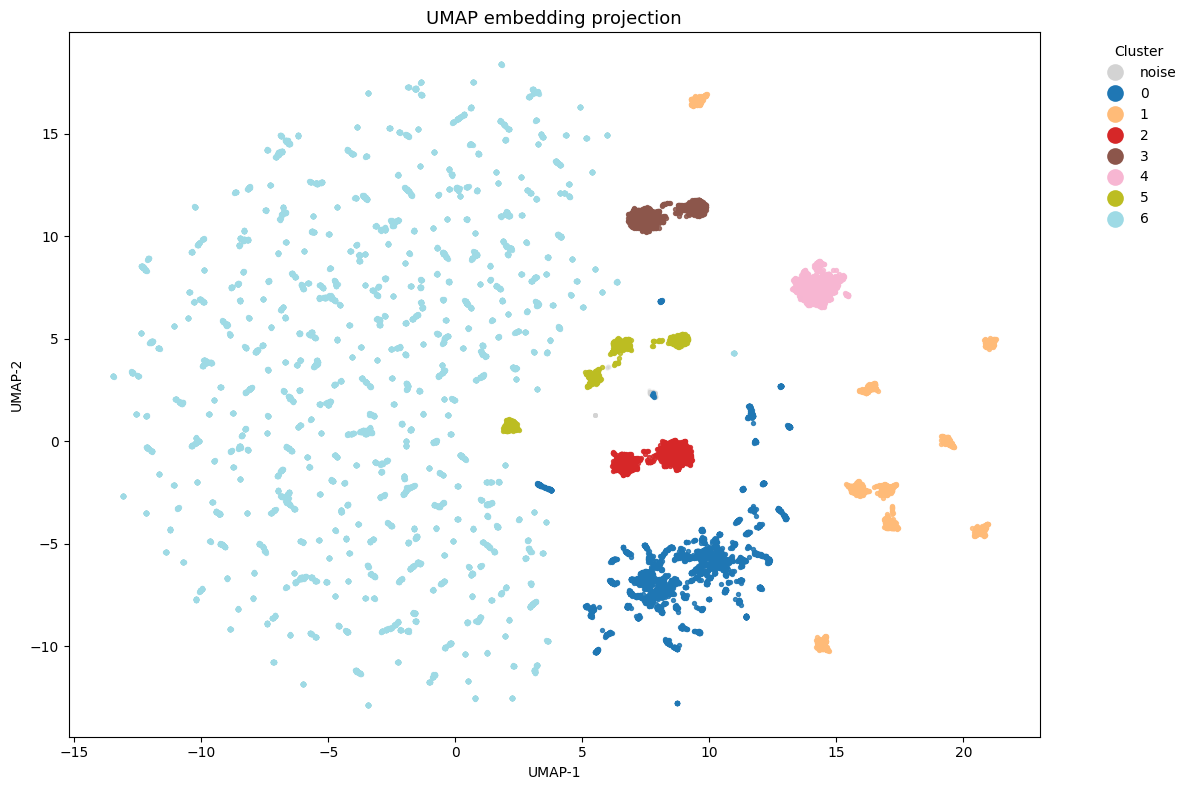

In [19]:
# pip install umap-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap

def visualize_clusters(logs_embeddings_clusters_mapping_df):
    embeddings = logs_embeddings_clusters_mapping_df["embedding"].tolist()

    df = logs_embeddings_clusters_mapping_df.copy()

    # 1) UMAP-проекция (можно оставить cosine; на unit-векторах также ок euclidean)
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,   # 30–50 — более «гладко»
        min_dist=0.1,     # 0.0 плотнее, 0.5 разреженней
        metric="cosine",
        random_state=42
    )
    X_umap = reducer.fit_transform(embeddings)

    # 2) Координаты в DF
    df["x"] = X_umap[:, 0]
    df["y"] = X_umap[:, 1]

    # 3) Визуализация
    plt.figure(figsize=(12, 8))

    is_noise = (df["cluster"] == -1)

    # шум серым
    plt.scatter(df.loc[is_noise, "x"], df.loc[is_noise, "y"],
                s=5, c="lightgray", alpha=0.30, label="noise")

    # кластеры цветами
    unique_clusters = sorted(df.loc[~is_noise, "cluster"].unique())
    cmap = cm.get_cmap("tab20", len(unique_clusters))
    for i, cid in enumerate(unique_clusters):
        sub = df[df["cluster"] == cid]
        plt.scatter(sub["x"], sub["y"], s=8, color=cmap(i), alpha=0.85)

    # легенда «цвет — номер кластера» (+ noise)
    handles, labels = [], []
    if is_noise.any():
        handles.append(plt.Line2D([0],[0], marker='o', linestyle='',
                                markerfacecolor='lightgray', markeredgecolor='none', markersize=8))
        labels.append("noise")
    handles += [plt.Line2D([0],[0], marker='o', linestyle='',
                        markerfacecolor=cmap(i), markeredgecolor='none', markersize=8)
                for i in range(len(unique_clusters))]
    labels += [str(cid) for cid in unique_clusters]

    plt.legend(handles, labels, title="Cluster",
            bbox_to_anchor=(1.05, 1), loc="upper left",
            frameon=False, markerscale=1.5)

    plt.title("UMAP embedding projection", fontsize=13)
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

    #опционально: подписи центров
    centers = df[df["cluster"] != -1].groupby("cluster")[["x","y"]].mean()
    for cid, row in centers.iterrows():
        plt.text(row["x"], row["y"], str(cid), fontsize=10, weight="bold")

visualize_clusters(log_emb_mapping_with_clusters_df)

In [20]:
logs_03_05_service_df['value_normalized'] = logs_03_05_service_df['value'].apply(normalize_log)
# use log_emb_mapping_with_clusters_df for mapping
logs_03_05_service_df['cluster'] = logs_03_05_service_df['value_normalized'].map(log_emb_mapping_with_clusters_df.set_index('log_message')['cluster'])
logs_03_05_service_df.head()

,log_id,timestamp,cmdb_id,log_name,value,datetime,value_normalized,cluster
0,Cp6Bt38B8vQa58bZsQau,1651507200,frontend-1,log_frontend-service_application,"severity: debug, message: request complete",2022-05-02 16:00:00,"severity: debug, message: request complete",-1.0
1,EZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 16:00:00,Executing endpoint 'gRPC - /hipstershop.C...,-1.0
2,FZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,-1.0
3,Fp6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Request finished in 0.6231ms 200 applicat...,2022-05-02 16:00:00,Request finished in <NUM>.<NUM>ms <NUM> a...,-1.0
4,F56Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,-1.0


In [21]:
logs_03_05_service_df.to_parquet("/Users/arinagoncharova/Documents/diploma/repo/data/AIOps/preprocessed_after_analysis/e5_small_embeddings/logs_03_05_service_with_clusters.parquet", index=False)

### Move to baseline

In [22]:
# add cluster label into filtered_logs_10m_df
# apply normalization
filtered_logs_10m_df["normalized_value"] = filtered_logs_10m_df["value"].apply(normalize_log)

# add column cluster
filtered_logs_10m_df["cluster"] = filtered_logs_10m_df["normalized_value"].map(log_emb_mapping_with_clusters_df.set_index('log_message')['cluster'])
filtered_logs_10m_df.head()

,log_id,timestamp,cmdb_id,log_name,value,datetime,matched_incident_timestamp,normalized_value,cluster
230840,zKfot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,Request finished in 0.5828ms 200 applicat...,2022-05-02 17:52:09,2022-05-02 18:02:09,Request finished in <NUM>.<NUM>ms <NUM> a...,-1
230841,x6fot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 17:52:09,2022-05-02 18:02:09,Executing endpoint 'gRPC - /hipstershop.C...,-1
230842,qqfot38B8vQa58bZXEiH,1651513929,currencyservice-1,log_currencyservice-service_application,"severity: info, message: received conversion r...",2022-05-02 17:52:09,2022-05-02 18:02:09,"severity: info, message: received conversion r...",-1
230843,yKfot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,etCartAsync called with userId=7224362a-f1f1-4...,2022-05-02 17:52:09,2022-05-02 18:02:09,etCartAsync called with userId=<NUM>a-f<NUM>f<...,2
230844,zafot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 17:52:09,2022-05-02 18:02:09,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,-1


In [23]:
filtered_logs_10m_df.to_parquet("/Users/arinagoncharova/Documents/diploma/repo/data/AIOps/preprocessed_after_analysis/e5_small_embeddings/filtered_logs_10m_with_clusters_embeddings.parquet", index=False)

In [24]:
filtered_logs_10m_df = pd.read_parquet("/Users/arinagoncharova/Documents/diploma/repo/data/AIOps/preprocessed_after_analysis/e5_small_embeddings/filtered_logs_10m_with_clusters_embeddings.parquet")
filtered_logs_10m_df.head()

,log_id,timestamp,cmdb_id,log_name,value,datetime,matched_incident_timestamp,normalized_value,cluster
0,zKfot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,Request finished in 0.5828ms 200 applicat...,2022-05-02 17:52:09,2022-05-02 18:02:09,Request finished in <NUM>.<NUM>ms <NUM> a...,-1
1,x6fot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 17:52:09,2022-05-02 18:02:09,Executing endpoint 'gRPC - /hipstershop.C...,-1
2,qqfot38B8vQa58bZXEiH,1651513929,currencyservice-1,log_currencyservice-service_application,"severity: info, message: received conversion r...",2022-05-02 17:52:09,2022-05-02 18:02:09,"severity: info, message: received conversion r...",-1
3,yKfot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,etCartAsync called with userId=7224362a-f1f1-4...,2022-05-02 17:52:09,2022-05-02 18:02:09,etCartAsync called with userId=<NUM>a-f<NUM>f<...,2
4,zafot38B8vQa58bZYElw,1651513929,cartservice-1,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 17:52:09,2022-05-02 18:02:09,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,-1


In [25]:
import plotly.graph_objs as go
FREQ = '1min'
WINDOW_BEFORE = '30min'
WINDOW_AFTER  = '30min'
TOP_N = None  

CLUSTER_DESCRIPTIONS = {
    -1: "Шум",
    0:  "gRPC серверные ошибки / исключения",
    1:  "Добавление товара в корзину (AddItemAsync)",
    2:  "Изменение корзины (etCartAsync)",
    3:  "Очистка корзины (EmptyCartAsync)",
    4:  "Платёж / транзакция прошла успешно",
    5:  "Создание заказа (PlaceOrder)",
    6:  "Вызов рекомендательной системы (ListRecommendations)",
}

# data
logs = filtered_logs_10m_df.copy()
incidents = service_failures_03_05_df.copy()

# type conversion
logs['datetime'] = pd.to_datetime(logs['datetime'])
incidents['datetime'] = pd.to_datetime(incidents['datetime'])

# 'noise' -> -1
logs['cluster_num'] = pd.to_numeric(
    logs['cluster'].replace({'noise': -1}),
    errors='coerce'
).astype('Int64')

# plot 1 incident
def plot_incident_timeseries(t_fail, failure_type=None, cmbd_id=None):
    # window near incident
    t_start = t_fail - pd.Timedelta(WINDOW_BEFORE)
    t_end   = t_fail + pd.Timedelta(WINDOW_AFTER)

    df_win = logs[(logs['datetime'] >= t_start) & (logs['datetime'] <= t_end)].copy()

    # filter by service
    if cmbd_id is not None:
        for svc_col in ['cmbd_id', 'cmdb_id', 'service_id', 'service']:
            if svc_col in df_win.columns:
                df_win = df_win[df_win[svc_col] == cmbd_id]
                break

    if df_win.empty:
        print(f"No logs in time window {WINDOW_BEFORE}/{WINDOW_AFTER} around {t_fail} (cmbd_id={cmbd_id})")
        return

    # agregate logs with resampling
    counts = (
        df_win
        .set_index('datetime')
        .groupby('cluster_num')
        .resample(FREQ).size()
        .rename('count')
        .reset_index()
    )

    # order of clusters
    order = (
        counts.groupby('cluster_num')['count']
              .sum()
              .sort_values(ascending=False)
              .index.tolist()
    )
    # print starting counts for debugging
    print('Counts at start time:')
    print(counts[counts['datetime'] == counts['datetime'].min()])
    if TOP_N is not None:
        order = order[:TOP_N]

    # title
    title_bits = []
    if failure_type is not None:
        title_bits.append(f'Failure type: {failure_type}')
    if cmbd_id is not None:
        title_bits.append(f'CMBD: {cmbd_id}')
    title_bits.append(str(t_fail))
    title = ' | '.join(title_bits)

    # visualization
    fig = go.Figure()
    for cid in order:
        sub = counts[counts['cluster_num'] == cid]
        if sub.empty:
            continue
        legend_name = f"Cluster {int(cid)} — {CLUSTER_DESCRIPTIONS.get(int(cid), 'Неизвестный кластер')}"
        fig.add_trace(go.Scatter(
            x=sub['datetime'],
            y=sub['count'],
            mode='lines+markers',
            name=legend_name
        ))

    # red line - time of incident
    fig.add_shape(
        type="line",
        x0=t_fail, x1=t_fail,
        y0=0, y1=1,
        xref='x', yref='paper',
        line=dict(color='red', dash='dash')
    )
    fig.add_annotation(
        x=t_fail, y=1, xref='x', yref='paper',
        text='Failure', showarrow=False,
        font=dict(color='red'), yanchor='bottom'
    )

    fig.update_layout(
        title=title,
        xaxis_title='time',
        yaxis_title=f'log count per {FREQ}',
        legend_title='cluster (номер — описание)',
        width=950, height=480,
        hovermode='x unified'
    )
    fig.show()

   

# plotting ts of logs
for _, row in incidents.iterrows():
    t_fail = row['datetime']
    failure_type = row['failure_type'] if 'failure_type' in incidents.columns else None
    cmbd_id = row['cmbd_id'] if 'cmbd_id' in incidents.columns else None
    plot_incident_timeseries(t_fail, failure_type=failure_type, cmbd_id=cmbd_id)


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .resample(FREQ).size()


Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 19:21:00    339
21             0 2022-05-02 19:21:00     28
42             1 2022-05-02 19:21:00      1
63             2 2022-05-02 19:21:00     16
84             3 2022-05-02 19:21:00      1
105            4 2022-05-02 19:21:00      1
126            5 2022-05-02 19:21:00      1
147            6 2022-05-02 19:21:00     14


Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 20:22:00    778
21             0 2022-05-02 20:22:00     84
42             1 2022-05-02 20:22:00      3
63             2 2022-05-02 20:22:00     33
84             3 2022-05-02 20:22:00      1
105            4 2022-05-02 20:22:00      1
126            5 2022-05-02 20:22:00      1
147            6 2022-05-02 20:22:00     26


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 22:02:00     71
21             0 2022-05-02 22:02:00      1
42             1 2022-05-02 22:02:00      1
63             2 2022-05-02 22:02:00      4
144            6 2022-05-02 22:02:00      4


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 23:04:00    747
41             0 2022-05-02 23:04:00     94
82             1 2022-05-02 23:04:00      4
123            2 2022-05-02 23:04:00     38
284            6 2022-05-02 23:04:00     37


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 23:22:00    937
41             0 2022-05-02 23:22:00     85
82             1 2022-05-02 23:22:00      4
123            2 2022-05-02 23:22:00     43
164            3 2022-05-02 23:22:00      2
205            4 2022-05-02 23:22:00      2
246            5 2022-05-02 23:22:00      2
287            6 2022-05-02 23:22:00     38


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 00:33:00    297
21             0 2022-05-03 00:33:00     38
42             1 2022-05-03 00:33:00      2
63             2 2022-05-03 00:33:00     13
84             3 2022-05-03 00:33:00      1
105            4 2022-05-03 00:33:00      1
126            5 2022-05-03 00:33:00      1
147            6 2022-05-03 00:33:00     12


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 02:08:00   1060
39             0 2022-05-03 02:08:00    120
78             1 2022-05-03 02:08:00      3
117            2 2022-05-03 02:08:00     51
156            3 2022-05-03 02:08:00      2
195            4 2022-05-03 02:08:00      2
234            5 2022-05-03 02:08:00      2
273            6 2022-05-03 02:08:00     48


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 02:08:00   1060
39             0 2022-05-03 02:08:00    120
78             1 2022-05-03 02:08:00      3
117            2 2022-05-03 02:08:00     51
156            3 2022-05-03 02:08:00      2
195            4 2022-05-03 02:08:00      2
234            5 2022-05-03 02:08:00      2
273            6 2022-05-03 02:08:00     48


Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 04:09:00    668
41             0 2022-05-03 04:09:00     65
82             1 2022-05-03 04:09:00      2
123            2 2022-05-03 04:09:00     27
284            6 2022-05-03 04:09:00     18


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 04:14:00   4664
41             0 2022-05-03 04:14:00    454
82             1 2022-05-03 04:14:00     22
123            2 2022-05-03 04:14:00    208
164            3 2022-05-03 04:14:00     10
205            4 2022-05-03 04:14:00     10
246            5 2022-05-03 04:14:00     10
287            6 2022-05-03 04:14:00    181


Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 05:44:00   1181
21             0 2022-05-03 05:44:00    124
42             1 2022-05-03 05:44:00      7
63             2 2022-05-03 05:44:00     56
84             3 2022-05-03 05:44:00      2
105            4 2022-05-03 05:44:00      2
126            5 2022-05-03 05:44:00      2
147            6 2022-05-03 05:44:00     52


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 06:29:00    427
41             0 2022-05-03 06:29:00     65
82             1 2022-05-03 06:29:00      2
123            2 2022-05-03 06:29:00     21
164            3 2022-05-03 06:29:00      1
205            4 2022-05-03 06:29:00      1
246            5 2022-05-03 06:29:00      1
287            6 2022-05-03 06:29:00     21


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 06:43:00    876
41             0 2022-05-03 06:43:00    101
82             1 2022-05-03 06:43:00      2
123            2 2022-05-03 06:43:00     40
164            3 2022-05-03 06:43:00      1
205            4 2022-05-03 06:43:00      3
246            5 2022-05-03 06:43:00      1
287            6 2022-05-03 06:43:00     35


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 10:25:00    627
21             0 2022-05-03 10:25:00     58
42             1 2022-05-03 10:25:00      4
63             2 2022-05-03 10:25:00     29
144            6 2022-05-03 10:25:00     26


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 11:37:00   2494
21             0 2022-05-03 11:37:00    268
42             1 2022-05-03 11:37:00      7
63             2 2022-05-03 11:37:00    113
84             3 2022-05-03 11:37:00      5
105            4 2022-05-03 11:37:00      5
126            5 2022-05-03 11:37:00      5
147            6 2022-05-03 11:37:00     97


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 14:06:00    915
41             0 2022-05-03 14:06:00     94
82             1 2022-05-03 14:06:00      4
123            2 2022-05-03 14:06:00     42
164            3 2022-05-03 14:06:00      1
205            4 2022-05-03 14:06:00      1
246            5 2022-05-03 14:06:00      1
287            6 2022-05-03 14:06:00     36


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 14:06:00    915
58             0 2022-05-03 14:06:00     94
116            1 2022-05-03 14:06:00      4
174            2 2022-05-03 14:06:00     42
232            3 2022-05-03 14:06:00      1
290            4 2022-05-03 14:06:00      1
348            5 2022-05-03 14:06:00      1
406            6 2022-05-03 14:06:00     36


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 14:23:00    911
41             0 2022-05-03 14:23:00    120
82             1 2022-05-03 14:23:00      3
123            2 2022-05-03 14:23:00     42
164            3 2022-05-03 14:23:00      1
205            4 2022-05-03 14:23:00      1
246            5 2022-05-03 14:23:00      1
287            6 2022-05-03 14:23:00     37


Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 17:52:00   1454
21             0 2022-05-02 17:52:00    190
42             1 2022-05-02 17:52:00      1
63             2 2022-05-02 17:52:00     65
84             3 2022-05-02 17:52:00      1
104            4 2022-05-02 17:52:00      1
124            5 2022-05-02 17:52:00      1
144            6 2022-05-02 17:52:00     51


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-02 21:07:00   1390
21             0 2022-05-02 21:07:00    131
42             1 2022-05-02 21:07:00      5
63             2 2022-05-02 21:07:00     59
84             3 2022-05-02 21:07:00      3
105            4 2022-05-02 21:07:00      3
126            5 2022-05-02 21:07:00      3
147            6 2022-05-02 21:07:00     48


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Counts at start time:
     cluster_num            datetime  count
0             -1 2022-05-03 08:18:00   4559
21             0 2022-05-03 08:18:00    514
42             1 2022-05-03 08:18:00     10
63             2 2022-05-03 08:18:00    204
84             3 2022-05-03 08:18:00      9
104            4 2022-05-03 08:18:00      9
124            5 2022-05-03 08:18:00      9
144            6 2022-05-03 08:18:00    171


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/1363796591.py:56: FutureWarning:

DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [26]:
from datetime import timedelta
# datetime conversion
logs_03_05_service_df["datetime"] = pd.to_datetime(logs_03_05_service_df["datetime"])
service_failures_03_05_df["datetime"] = pd.to_datetime(service_failures_03_05_df["datetime"])

# failure intervals 30 minutes before and after
failure_intervals = []
for t in service_failures_03_05_df["datetime"]:
    failure_intervals.append((t - timedelta(minutes=30), t + timedelta(minutes=30)))

# exclude failure intervals
mask = pd.Series(True, index=logs_03_05_service_df.index)
for start, end in failure_intervals:
    mask &= ~((logs_03_05_service_df["datetime"] >= start) & (logs_03_05_service_df["datetime"] <= end))

normal_logs_df = logs_03_05_service_df[mask].copy()

print(f"Всего логов: {len(logs_03_05_service_df)}")
print(f"Нормальных логов: {len(normal_logs_df)}")
normal_logs_df.head()


/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/4163380148.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Всего логов: 5444332
Нормальных логов: 1778077


,log_id,timestamp,cmdb_id,log_name,value,datetime,value_normalized,cluster
0,Cp6Bt38B8vQa58bZsQau,1651507200,frontend-1,log_frontend-service_application,"severity: debug, message: request complete",2022-05-02 16:00:00,"severity: debug, message: request complete",-1.0
1,EZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Executing endpoint 'gRPC - /hipstershop.C...,2022-05-02 16:00:00,Executing endpoint 'gRPC - /hipstershop.C...,-1.0
2,FZ6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,-1.0
3,Fp6Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,Request finished in 0.6231ms 200 applicat...,2022-05-02 16:00:00,Request finished in <NUM>.<NUM>ms <NUM> a...,-1.0
4,F56Bt38B8vQa58bZqQWr,1651507200,cartservice-2,log_cartservice-service_application,[40m[32minfo[39m[22m[49m: Microsoft.AspNet...,2022-05-02 16:00:00,[<NUM>m[<NUM>minfo[<NUM>m[<NUM>m[<NUM>m: M...,-1.0


In [27]:
logs_03_05_service_df.to_parquet('all_logs_with_cluster.parquet', index=False)

In [28]:
normal_logs_df.to_parquet('normal_logs_with_cluster.parquet', index=False)

In [29]:
filtered_logs_10m_df.to_parquet('incident_logs.parquet', index=False)

In [30]:
normal_logs_df['cluster'].value_counts()

cluster
-1.0    1492715
 0.0     143096
 6.0      53813
Name: count, dtype: int64

In [31]:
# add target label
filtered_logs_10m_df["state"] = "failure"
normal_logs_df["state"] = "normal"

# merge normal and incident logs
logs_preprocessed_df = pd.concat([filtered_logs_10m_df, normal_logs_df], ignore_index=True)

In [32]:
logs_preprocessed_df['cluster'].fillna(-1, inplace=True)
# fill cluster noise as -1
logs_preprocessed_df['cluster'].replace('noise', -1, inplace=True)
logs_preprocessed_df['cluster'] = logs_preprocessed_df['cluster'].astype(int)

/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/400467482.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_5008/400467482.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

In [33]:
logs_preprocessed_df = logs_preprocessed_df.sort_values("datetime")

# Выберем шаг агрегации (например, 1 минута)
window = "1min"

# Посмотрим, какие есть кластеры
clusters = sorted(logs_preprocessed_df["cluster"].dropna().unique())
print("Кластеры:", clusters)

Кластеры: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


In [34]:
logs_preprocessed_df.to_parquet('all_logs_prepeocessed.parquet', index=False)

In [35]:
# group by time and cluster, count num of logs
logs_per_minute_df = (
    logs_preprocessed_df
    .groupby([pd.Grouper(key="datetime", freq=window), "cluster", "state"])
    .size()
    .reset_index(name="count")
)

logs_per_minute_df.head()

,datetime,cluster,state,count
0,2022-05-02 16:00:00,-1,normal,2037
1,2022-05-02 16:00:00,0,normal,229
2,2022-05-02 16:00:00,6,normal,56
3,2022-05-02 16:01:00,-1,normal,1537
4,2022-05-02 16:01:00,0,normal,118


In [36]:
# convert cluster to separate columns
logs_pivot_df = logs_per_minute_df.pivot_table(
    index=["datetime", "state"],
    columns="cluster",
    values="count",
    fill_value=0
).reset_index()

# column names
logs_pivot_df.columns = [f"cluster_{c}" if isinstance(c, (int, str)) and str(c).isdigit() else c for c in logs_pivot_df.columns]

logs_pivot_df.head()

,datetime,state,-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
0,2022-05-02 16:00:00,normal,2037.0,229.0,0.0,0.0,0.0,0.0,0.0,56.0
1,2022-05-02 16:01:00,normal,1537.0,118.0,0.0,0.0,0.0,0.0,0.0,61.0
2,2022-05-02 16:02:00,normal,2026.0,208.0,0.0,0.0,0.0,0.0,0.0,53.0
3,2022-05-02 16:03:00,normal,1704.0,129.0,0.0,0.0,0.0,0.0,0.0,64.0
4,2022-05-02 16:04:00,normal,1948.0,194.0,0.0,0.0,0.0,0.0,0.0,63.0


In [37]:
normal_logs_df['cluster'].value_counts()

cluster
-1.0    1492715
 0.0     143096
 6.0      53813
Name: count, dtype: int64

In [38]:
logs_pivot_df.columns = logs_pivot_df.columns.map(str)
# add rolling mean and difference for each cluster
for c in [col for col in logs_pivot_df.columns if col.startswith("cluster_")]:
    logs_pivot_df[f"{c}_mean3"] = logs_pivot_df[c].rolling(window=3, min_periods=1).mean()
    logs_pivot_df[f"{c}_diff1"] = logs_pivot_df[c].diff()

In [39]:
logs_pivot_df.head()

,datetime,state,-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,...,cluster_2_mean3,cluster_2_diff1,cluster_3_mean3,cluster_3_diff1,cluster_4_mean3,cluster_4_diff1,cluster_5_mean3,cluster_5_diff1,cluster_6_mean3,cluster_6_diff1
0,2022-05-02 16:00:00,normal,2037.0,229.0,0.0,0.0,0.0,0.0,0.0,56.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,56.000000,NaN
1,2022-05-02 16:01:00,normal,1537.0,118.0,0.0,0.0,0.0,0.0,0.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.500000,5.0
2,2022-05-02 16:02:00,normal,2026.0,208.0,0.0,0.0,0.0,0.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.666667,-8.0
3,2022-05-02 16:03:00,normal,1704.0,129.0,0.0,0.0,0.0,0.0,0.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.333333,11.0
4,2022-05-02 16:04:00,normal,1948.0,194.0,0.0,0.0,0.0,0.0,0.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,-1.0


In [40]:
logs_pivot_df.to_parquet("logs_preprocessed_for_classification.parquet", index=False)

In [41]:
logs_pivot_df = logs_pivot_df.fillna(0)

# features for training
feature_df = logs_pivot_df.copy()
feature_df.head()

,datetime,state,-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,...,cluster_2_mean3,cluster_2_diff1,cluster_3_mean3,cluster_3_diff1,cluster_4_mean3,cluster_4_diff1,cluster_5_mean3,cluster_5_diff1,cluster_6_mean3,cluster_6_diff1
0,2022-05-02 16:00:00,normal,2037.0,229.0,0.0,0.0,0.0,0.0,0.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.000000,0.0
1,2022-05-02 16:01:00,normal,1537.0,118.0,0.0,0.0,0.0,0.0,0.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.500000,5.0
2,2022-05-02 16:02:00,normal,2026.0,208.0,0.0,0.0,0.0,0.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.666667,-8.0
3,2022-05-02 16:03:00,normal,1704.0,129.0,0.0,0.0,0.0,0.0,0.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.333333,11.0
4,2022-05-02 16:04:00,normal,1948.0,194.0,0.0,0.0,0.0,0.0,0.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,-1.0


In [42]:
feature_df.to_parquet('logs_prepared_for_training.parquet', index=False)

In [ ]:
feature_df = pd.read_parquet('logs_prepared_for_training.parquet')

In [ ]:
from sklearn.model_selection import train_test_split

X = feature_df.drop(columns=["datetime", "state"])
y = feature_df["state"].map({"normal": 0, "failure": 1})

# without shuffling because of time dependence
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)


: 

In [ ]:
import os
metrics_root = "Aiops-Dataset/data/2022-05-03/metric"

all_metrics = []

for root, dirs, files in os.walk(metrics_root):
    for f in files:
        if f.endswith(".csv"):
            file_path = os.path.join(root, f)
            try:
                df = pd.read_csv(file_path)
                all_metrics.append(df)
            except Exception as e:
                print(f"Error while reading {file_path}: {e}")

# combine all metrics into a single dataframe
metrics_df = pd.concat(all_metrics, ignore_index=True)
print(f"Total metrics: {len(metrics_df):,}")
metrics_df.head()


Total metrics: 7,599,784


,timestamp,cmdb_id,kpi_name,value,service,rr,sr,mrt,count
0,1651507200,istio-egressgateway-7bfdcc9d86-g2d4q,istio_agent_startup_duration_seconds,1.346764,NaN,NaN,NaN,NaN,NaN
1,1651507200,istio-ingressgateway-565bffd4d-rn678,istio_agent_startup_duration_seconds,1.529217,NaN,NaN,NaN,NaN,NaN
2,1651507260,istio-egressgateway-7bfdcc9d86-g2d4q,istio_agent_startup_duration_seconds,1.346764,NaN,NaN,NaN,NaN,NaN
3,1651507260,istio-ingressgateway-565bffd4d-rn678,istio_agent_startup_duration_seconds,1.529217,NaN,NaN,NaN,NaN,NaN
4,1651507320,istio-egressgateway-7bfdcc9d86-g2d4q,istio_agent_startup_duration_seconds,1.346764,NaN,NaN,NaN,NaN,NaN


In [ ]:
metrics_df["datetime"] = pd.to_datetime(metrics_df["timestamp"], unit="s")
metrics_df = metrics_df.sort_values("datetime")

In [ ]:
# check for nulls
nulls = metrics_df.isnull().sum()
print("Number of missing values in each column:")
print(nulls[nulls > 0])

Number of missing values in each column:
cmdb_id       15832
kpi_name      15832
value         15832
service     7583952
rr          7583952
sr          7583952
mrt         7583952
count       7583952
dtype: int64


rr - response rate

sr - success rate

mrt - mean response time

In [ ]:
# check where cmdb_id is null
print("Rows with null cmdb_id:")
print(metrics_df[metrics_df['cmdb_id'].isnull()].head())

Rows with null cmdb_id:
          timestamp cmdb_id kpi_name  value                     service  \
7583960  1651507200     NaN      NaN    NaN  productcatalogservice-grpc   
7583959  1651507200     NaN      NaN    NaN  recommendationservice-grpc   
7583958  1651507200     NaN      NaN    NaN               frontend-http   
7583957  1651507200     NaN      NaN    NaN        currencyservice-grpc   
7583956  1651507200     NaN      NaN    NaN        shippingservice-grpc   

            rr     sr         mrt  count            datetime  
7583960  100.0  100.0    3.529355  620.0 2022-05-02 16:00:00  
7583959  100.0  100.0    3.132474   97.0 2022-05-02 16:00:00  
7583958  100.0  100.0  156.752174  115.0 2022-05-02 16:00:00  
7583957  100.0  100.0   38.421574  343.0 2022-05-02 16:00:00  
7583956  100.0  100.0    0.000000    1.0 2022-05-02 16:00:00  


In [ ]:
metrics_low_df = metrics_df[metrics_df["cmdb_id"].notna()].copy()
metrics_high_df = metrics_df[metrics_df["cmdb_id"].isna()].copy()
print(metrics_low_df.shape, metrics_high_df.shape)

(7583952, 10) (15832, 10)


In [ ]:
from datetime import timedelta

service_failures_03_05_df["datetime"] = pd.to_datetime(service_failures_03_05_df["datetime"])

def label_state(time):
    for fail_time in service_failures_03_05_df["datetime"]:
        if (fail_time - timedelta(minutes=30)) <= time <= (fail_time + timedelta(minutes=30)):
            return "failure"
    return "normal"

metrics_high_df["state"] = metrics_high_df["datetime"].apply(label_state)

/var/folders/9k/3f86r_td4ygg_zflr8hnwkjr0000gn/T/ipykernel_35200/2725888888.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
metrics_high_df["state"].value_counts()

state
failure    11080
normal      4752
Name: count, dtype: int64

In [ ]:
metrics_high_agg = (
    metrics_high_df
    .groupby([pd.Grouper(key="datetime", freq="1min"), "service", "state"])
    .agg({
        "rr": "mean",
        "sr": "mean",
        "mrt": "mean",
        "count": "sum"
    })
    .reset_index()
)
metrics_high_agg.head()

,datetime,service,state,rr,sr,mrt,count
0,2022-05-02 16:00:00,adservice-grpc,normal,100.0,75.221239,2.315487,113.0
1,2022-05-02 16:00:00,adservice-http,normal,100.0,100.000000,8.931250,24.0
2,2022-05-02 16:00:00,cartservice-grpc,normal,100.0,100.000000,1.003540,113.0
3,2022-05-02 16:00:00,checkoutservice-grpc,normal,100.0,100.000000,0.000000,0.0
4,2022-05-02 16:00:00,currencyservice-grpc,normal,100.0,100.000000,38.421574,343.0


In [ ]:
X = metrics_high_agg[["rr", "sr", "mrt", "count"]]
y = metrics_high_agg["state"].map({"normal": 0, "failure": 1})

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.49      0.10      0.16      2244
           1       0.53      0.91      0.67      2506

    accuracy                           0.53      4750
   macro avg       0.51      0.50      0.42      4750
weighted avg       0.51      0.53      0.43      4750



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import pandas as pd

# Предполагаем, что у тебя уже есть:
# metrics_high_agg — датафрейм с колонками ['datetime','service','state','rr','sr','mrt','count']

X = metrics_high_agg[["rr", "sr", "mrt", "count"]].fillna(0)
y = metrics_high_agg["state"].map({"normal": 0, "failure": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe["model"], "predict_proba") else y_pred
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
results_df


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.46      0.72      0.56      2244
           1       0.48      0.24      0.32      2506

    accuracy                           0.46      4750
   macro avg       0.47      0.48      0.44      4750
weighted avg       0.47      0.46      0.43      4750

Model: DecisionTree
              precision    recall  f1-score   support

           0       0.50      0.19      0.28      2244
           1       0.53      0.83      0.65      2506

    accuracy                           0.53      4750
   macro avg       0.52      0.51      0.46      4750
weighted avg       0.52      0.53      0.47      4750

Model: RandomForest
              precision    recall  f1-score   support

           0       0.50      0.09      0.16      2244
           1       0.53      0.92      0.67      2506

    accuracy                           0.53      4750
   macro avg       0.52      0.51      0.42      4750
weighted

/Users/arinagoncharova/venvs/py312-jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/Users/arinagoncharova/venvs/py312-jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



,Model,F1,ROC-AUC
1,DecisionTree,0.648920,0.503849
3,NaiveBayes,0.040489,0.488822
0,LogisticRegression,0.315930,0.482234
4,KNN,0.649222,0.476590
2,RandomForest,0.672323,0.470003
5,LightGBM,0.683847,0.447956


In [ ]:
# add diff and rolling mean for metrics
# sort by service and datetime
metrics_high_agg = metrics_high_agg.sort_values(["service", "datetime"]).copy()

# add rolling mean and diff for each metric grouped by service
for metric in ["rr", "sr", "mrt", "count"]:
    metrics_high_agg[f"{metric}_mean3"] = (
        metrics_high_agg.groupby("service")[metric]
        .rolling(window=3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    metrics_high_agg[f"{metric}_diff1"] = (
        metrics_high_agg.groupby("service")[metric]
        .diff()
        .fillna(0)
    )

In [ ]:
feature_cols = [
    "rr", "sr", "mrt", "count",
    "rr_mean3", "sr_mean3", "mrt_mean3", "count_mean3",
    "rr_diff1", "sr_diff1", "mrt_diff1", "count_diff1"
]

X = metrics_high_agg[feature_cols].fillna(0)
y = metrics_high_agg["state"].map({"normal": 0, "failure": 1})


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe["model"], "predict_proba") else y_pred
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print(results_df)


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.32      0.99      0.48      1500
           1       0.74      0.01      0.03      3250

    accuracy                           0.32      4750
   macro avg       0.53      0.50      0.25      4750
weighted avg       0.60      0.32      0.17      4750

Model: DecisionTree
              precision    recall  f1-score   support

           0       0.34      0.56      0.42      1500
           1       0.71      0.49      0.58      3250

    accuracy                           0.51      4750
   macro avg       0.52      0.53      0.50      4750
weighted avg       0.59      0.51      0.53      4750

Model: RandomForest
              precision    recall  f1-score   support

           0       0.28      0.14      0.19      1500
           1       0.68      0.84      0.75      3250

    accuracy                           0.62      4750
   macro avg       0.48      0.49      0.47      4750
weighted

/Users/arinagoncharova/venvs/py312-jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/Users/arinagoncharova/venvs/py312-jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



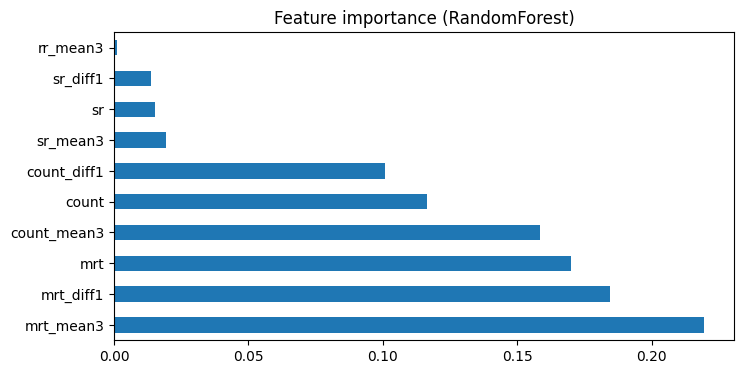

In [ ]:
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.head(10).plot(kind="barh")
plt.title("Feature importance (RandomForest)")
plt.show()


In [ ]:
# datetime conversion and sorting
logs_pivot_df["datetime"] = pd.to_datetime(logs_pivot_df["datetime"])
metrics_high_agg["datetime"] = pd.to_datetime(metrics_high_agg["datetime"])

logs_pivot_df = logs_pivot_df.sort_values("datetime")
metrics_high_agg = metrics_high_agg.sort_values("datetime")

# Merge nearest records (within one minute)
combined_df = pd.merge_asof(
    logs_pivot_df,
    metrics_high_agg,
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)
combined_df.head()


,datetime,state_x,-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,...,mrt,count,rr_mean3,rr_diff1,sr_mean3,sr_diff1,mrt_mean3,mrt_diff1,count_mean3,count_diff1
0,2022-05-02 16:00:00,normal,1401.0,82.0,286.0,0.0,168.0,286.0,17.0,82.0,...,0.000000,0.0,100.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2022-05-02 16:01:00,normal,1164.0,69.0,123.0,0.0,168.0,123.0,0.0,69.0,...,156.752174,115.0,100.0,0.0,100.000000,0.000000,156.752174,0.000000,115.000000,0.0
2,2022-05-02 16:02:00,normal,1415.0,79.0,265.0,0.0,170.0,265.0,14.0,79.0,...,0.046324,68.0,100.0,0.0,100.000000,0.000000,0.015441,0.046324,23.333333,67.0
3,2022-05-02 16:03:00,normal,1246.0,72.0,163.0,0.0,178.0,163.0,3.0,72.0,...,2.380097,103.0,100.0,0.0,76.831616,-3.817299,2.340195,0.055097,86.666667,59.0
4,2022-05-02 16:04:00,normal,1396.0,82.0,229.0,0.0,176.0,229.0,11.0,82.0,...,139.944444,9.0,100.0,0.0,100.000000,0.000000,133.296296,64.944444,6.333333,8.0


In [ ]:
if "state_x" in combined_df.columns and "state_y" in combined_df.columns:
    combined_df["state"] = combined_df["state_x"].combine_first(combined_df["state_y"])
    combined_df = combined_df.drop(columns=["state_x", "state_y"])

# fill missing values with 0
combined_df = combined_df.fillna(0)

In [ ]:
X = combined_df.select_dtypes(include=["number"]).drop(columns=["timestamp"], errors="ignore")
y = combined_df["state"].map({"normal": 0, "failure": 1})

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, roc_auc_score
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe["model"], "predict_proba") else y_pred
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
results_df


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.76      0.66      0.70       163
           1       0.54      0.66      0.59       100

    accuracy                           0.66       263
   macro avg       0.65      0.66      0.65       263
weighted avg       0.68      0.66      0.66       263

Model: DecisionTree
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       163
           1       0.50      0.69      0.58       100

    accuracy                           0.62       263
   macro avg       0.62      0.63      0.61       263
weighted avg       0.65      0.62      0.62       263

Model: RandomForest
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       163
           1       0.53      0.65      0.59       100

    accuracy                           0.65       263
   macro avg       0.64      0.65      0.64       263
weighted

/Users/arinagoncharova/venvs/py312-jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/Users/arinagoncharova/venvs/py312-jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



,Model,F1,ROC-AUC
2,RandomForest,0.585586,0.755368
5,LightGBM,0.577778,0.724724
1,DecisionTree,0.577406,0.684356
4,KNN,0.551111,0.652454
0,LogisticRegression,0.594595,0.629325
3,NaiveBayes,0.056075,0.600368


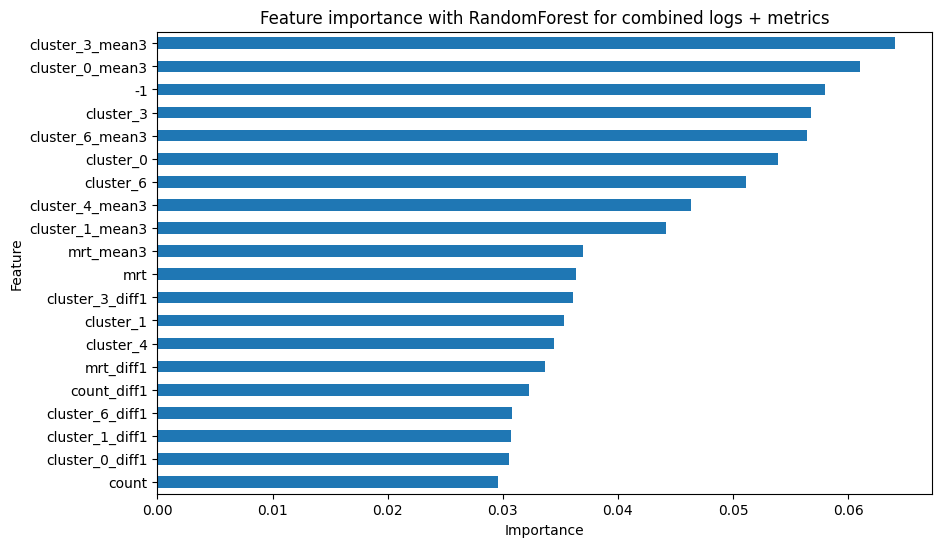

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='barh')
plt.title("Feature importance with RandomForest for combined logs + metrics")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()
